In [12]:
import numpy as np
import json
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Загружаем предвычесленные фичи
OPENMIC = np.load('data/openmic-2018/openmic-2018.npz', allow_pickle=True)
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']

# Загружаем словарь-маппер инструментов
with open('data/openmic-2018/class-map.json', 'r') as f:
    instrument_to_idx = json.load(f)

idx_to_instrument = { value:key for key, value in instrument_to_idx.items()}

# Создатели open-mic-2018 разделили на тренировочную и тестовые выборки по 14915 и 5085 соответственно
split_train = set(pd.read_csv('data/openmic-2018/partitions/split01_train.csv',
                              header=None).squeeze())

split_test = set(pd.read_csv('data/openmic-2018/partitions/split01_test.csv',
                             header=None).squeeze())

train_set = set(split_train)
test_set = set(split_test)

idx_train, idx_test = [], []

for idx, n in enumerate(sample_key):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(sample_key[n]))

# Получаем индексы, по которым будем делить данные
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

# Sample[n] : timestamp[10] : features[128]
X_train = X[idx_train]
X_test = X[idx_test]

# Sample[n] : Уверенности в наличие инструмента[20]
Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]

# Sample[n] : Известно ли наличие инструмента[20]
Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

In [26]:
print(f'Тренировочных данных всего: {idx_train.shape[0]} Тестовых данных всего: {idx_test.shape[0]} Всего: {Y_true.shape[0]}')

Тренировочных данных всего: 14915 Тестовых данных всего: 5085 Всего: 20000


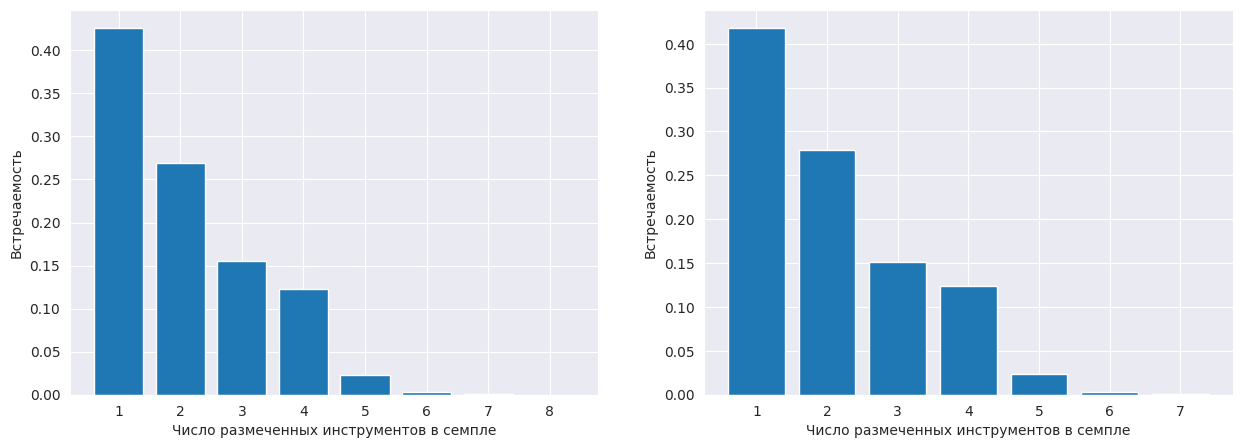

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

unique1, counts1 = np.unique(Y_mask_train.sum(axis=1), return_counts=True)
ax1.bar(unique1, counts1 / sum(counts1))
ax1.set_xlabel('Число размеченных инструментов в семпле')
ax1.set_ylabel('Встречаемость')

unique2, counts2 = np.unique(Y_mask_test.sum(axis=1), return_counts=True)
ax2.bar(unique2, counts2 / sum(counts2))
ax2.set_xlabel('Число размеченных инструментов в семпле')
ax2.set_ylabel('Встречаемость')

plt.show()

Видим, что чаще всего для трека известно наличие или отсутствие всего одного - двух инструментов. Это важно при выборе метрик

In [35]:
treshold = 0.5

print('TRAIN')
for instrument in instrument_to_idx:
    inst_num = instrument_to_idx[instrument]

    mask_inst = Y_mask_train[:, inst_num]
    Y_true_inst = Y_true_train[mask_inst, inst_num] >= treshold

    total = Y_true_inst.shape[0]
    true_at_treshold = Y_true_inst.sum()
    print(f'Инструмент: {instrument}, Всего наблюдений: {total}, Положительных: {true_at_treshold}, Отрицательных: {total - true_at_treshold}')


TRAIN
Инструмент: accordion, Всего наблюдений: 1533, Положительных: 374, Отрицательных: 1159
Инструмент: banjo, Всего наблюдений: 1740, Положительных: 592, Отрицательных: 1148
Инструмент: bass, Всего наблюдений: 1425, Положительных: 415, Отрицательных: 1010
Инструмент: cello, Всего наблюдений: 1464, Положительных: 598, Отрицательных: 866
Инструмент: clarinet, Всего наблюдений: 1745, Положительных: 396, Отрицательных: 1349
Инструмент: cymbals, Всего наблюдений: 1299, Положительных: 814, Отрицательных: 485
Инструмент: drums, Всего наблюдений: 1323, Положительных: 828, Отрицательных: 495
Инструмент: flute, Всего наблюдений: 1522, Положительных: 472, Отрицательных: 1050
Инструмент: guitar, Всего наблюдений: 1214, Положительных: 852, Отрицательных: 362
Инструмент: mallet_percussion, Всего наблюдений: 1324, Положительных: 522, Отрицательных: 802
Инструмент: mandolin, Всего наблюдений: 1837, Положительных: 652, Отрицательных: 1185
Инструмент: organ, Всего наблюдений: 1459, Положительных: 482,

In [36]:
treshold = 0.5

print('TEST')
for instrument in instrument_to_idx:
    inst_num = instrument_to_idx[instrument]

    mask_inst = Y_mask_test[:, inst_num]
    Y_true_inst = Y_true_test[mask_inst, inst_num] >= treshold

    total = Y_true_inst.shape[0]
    true_at_treshold = Y_true_inst.sum()
    print(f'Инструмент: {instrument}, Всего наблюдений: {total}, Положительных: {true_at_treshold}, Отрицательных: {total - true_at_treshold}')


TEST
Инструмент: accordion, Всего наблюдений: 538, Положительных: 115, Отрицательных: 423
Инструмент: banjo, Всего наблюдений: 478, Положительных: 140, Отрицательных: 338
Инструмент: bass, Всего наблюдений: 463, Положительных: 134, Отрицательных: 329
Инструмент: cello, Всего наблюдений: 485, Положительных: 226, Отрицательных: 259
Инструмент: clarinet, Всего наблюдений: 640, Положительных: 137, Отрицательных: 503
Инструмент: cymbals, Всего наблюдений: 436, Положительных: 297, Отрицательных: 139
Инструмент: drums, Всего наблюдений: 424, Положительных: 278, Отрицательных: 146
Инструмент: flute, Всего наблюдений: 562, Положительных: 175, Отрицательных: 387
Инструмент: guitar, Всего наблюдений: 436, Положительных: 286, Отрицательных: 150
Инструмент: mallet_percussion, Всего наблюдений: 478, Положительных: 211, Отрицательных: 267
Инструмент: mandolin, Всего наблюдений: 627, Положительных: 193, Отрицательных: 434
Инструмент: organ, Всего наблюдений: 431, Положительных: 121, Отрицательных: 310

Видим, что по каждому инструменту примерно равное количество наблюдений всего (одного порядка). Однако для части инструментов больше положительных семплов (классифицированные как имеющие данный инструмент), для другой части больше отрицательных(в семпле не звучит данный инструмент)